In [ ]:
"""
Aircraft Hub Inspection Predictive Modeling
==========================================
Predicting crack occurrences in aircraft wheel hubs using machine learning.
Target: 82% recall achieved with Weighted XGBoost for safety-critical application.

Dataset: 385 Type 05 MW hub inspection records (14% crack rate)
Method: Progressive model complexity with focus on recall optimization
"""

'\nAircraft Hub Inspection Predictive Modeling\n==========================================\nPredicting crack occurrences in aircraft wheel hubs using machine learning.\nTarget: 82% recall achieved with Weighted XGBoost for safety-critical application.\n\nDataset: 385 A350 Main Wheel hub inspection records (14% crack rate)\nMethod: Progressive model complexity with focus on recall optimization\n'

In [2]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
import shap

In [ ]:
# Defining Model evaluation function
def evaluate_model(model, X_test, y_test):
    """Model evaluation with basic metrics and plots"""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    # Print metrics
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}") 
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    
    # Plot confusion matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.show()

In [ ]:
# Read csv file
df = pd.read_csv(r"\Type 05 MW_clean.csv")

In [5]:
## Hub Cycle vs Crack Correlation
corr, pval = pointbiserialr(df['Cycle'],df['Result'])
print(f"Correlation: {corr:.4f}, P-value: {pval:.4f}")

Correlation: 0.0669, P-value: 0.1900


In [6]:
## Total Inspections per Inspector vs Crack Correlation
inspections_per_inspector = df.groupby('Inspector ID').size().reset_index(name='Total Inspections')
df = df.merge(inspections_per_inspector, on='Inspector ID')
corr, pval = pointbiserialr(df['Total Inspections'],df['Result'])
print(f"Correlation: {corr:.4f}, P-value: {pval:.4f}")

Correlation: 0.0895, P-value: 0.0793


In [7]:
## Inspector vs Crack Correlation
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0] # Chi-squared statistic
    n = confusion_matrix.sum() # Total observations
    phi2 = chi2/n # Phi-squared (effect size)
    r, k = confusion_matrix.shape # Rows/columns in table
    # Bias correction for small samples
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

contingency_table = pd.crosstab(df['Inspector ID'],df['Result'])
print(f"Cramer's V Correlation: {cramers_v(contingency_table.values)}")

Cramer's V Correlation: 0.0


In [8]:
## Data Preprocessing
X = df.drop(columns=['Result','Relative Day','Type ID','Result_Info','Book'])
y = df['Result']
X_encoded = pd.get_dummies(X, columns=['PN ID', 'Inspector ID', 'Inspector Bin'], drop_first=True)
scaler = StandardScaler()
X_encoded[['Cycle','Total Inspections']] = scaler.fit_transform(X_encoded[['Cycle','Total Inspections']] )
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

Logistic Regression Results

Accuracy: 0.8571
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC: 0.5117


c:\Users\faizf\Desktop\Portfolio Project\Project 3\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


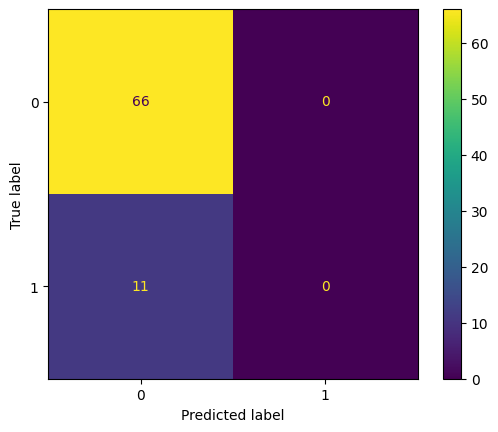

In [28]:
## Logistic Regression Model
print("Logistic Regression Results")
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)
evaluate_model(logreg, X_test, y_test)

Random Forest Results

Accuracy: 0.6364
Precision: 0.1852
Recall: 0.4545
F1 Score: 0.2632
ROC AUC: 0.6164


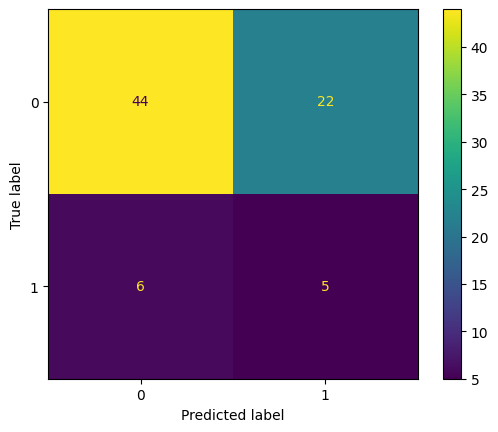

In [27]:
## Random Forest Model
print("Random Forest Results") 
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test)

In [30]:
# Feature Importance (Random Forest)
rf_feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_}).sort_values('Importance', ascending=False)
print("\nTop 5 Features (Random Forest):")
print(rf_feature_importance.head(5))


Top 5 Features (Random Forest):
                     Feature  Importance
0                      Cycle    0.426248
1          Total Inspections    0.140772
4                PN ID_PN008    0.137749
3                PN ID_PN007    0.043310
7  Inspector ID_Inspector 03    0.037093


SMOTE Random Forest Results

Accuracy: 0.7792
Precision: 0.2500
Recall: 0.2727
F1 Score: 0.2609
ROC AUC: 0.6288


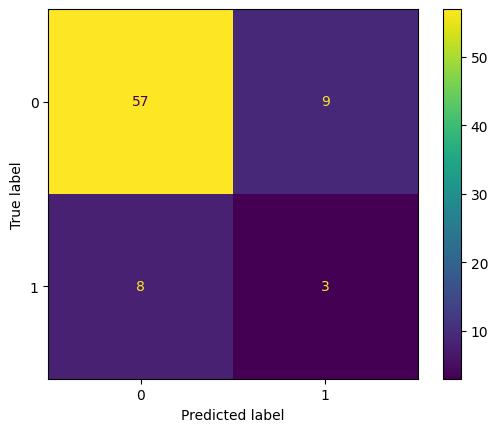

In [26]:
## SMOTE Application
print("SMOTE Random Forest Results")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)
evaluate_model(rf_smote, X_test, y_test)

XGBoost Results

Accuracy: 0.5195
Precision: 0.2045
Recall: 0.8182
F1 Score: 0.3273
ROC AUC: 0.6605


c:\Users\faizf\Desktop\Portfolio Project\Project 3\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:26:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


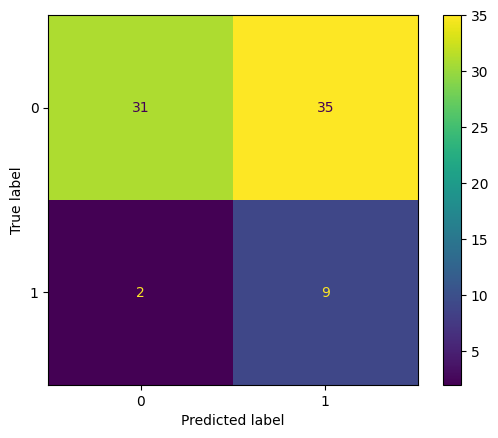

In [25]:
## XGBoost Model
print("XGBoost Results")
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
xgb_model = XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    use_label_encoder=False, 
    eval_metric='aucpr',
    random_state=42,
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])
    )
xgb_model.fit(X_train_resampled, y_train_resampled)
evaluate_model(xgb_model, X_test, y_test)

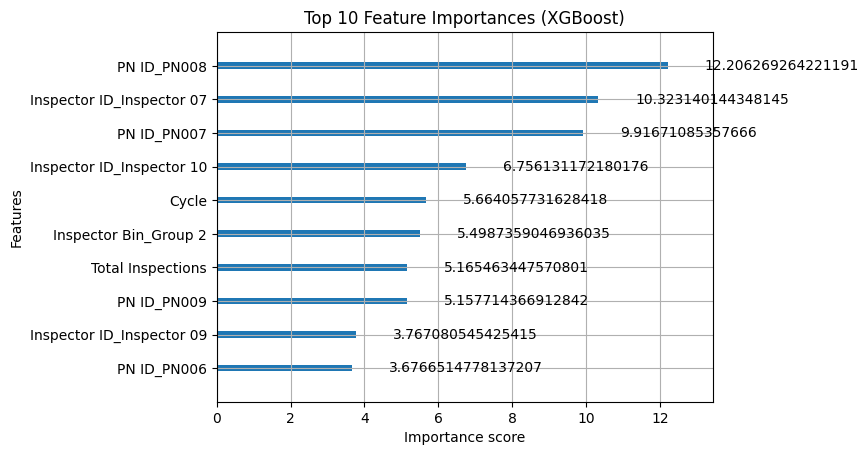

In [14]:
# XGBoost Feature Importance
xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=10)
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()

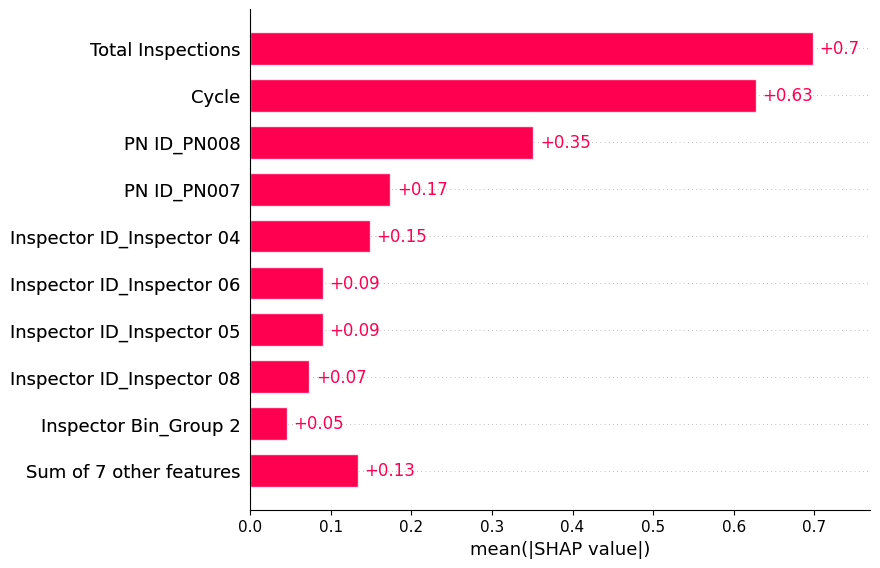

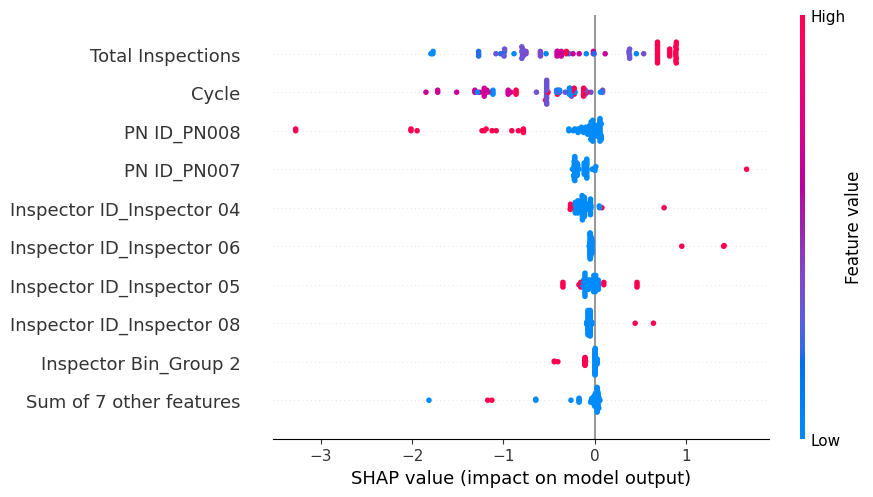

In [17]:
# SHAP Analysis
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X_test)
shap.plots.bar(shap_values, max_display=10)
shap.plots.beeswarm(shap_values, max_display=10)